# Setup initial code environment

1) Make sure we can reload python files when we make changes.
2) Load the base-notebook which will download all the python utility files and check versions of TensorFlow and Python.
3) Setup imports we will need for this notebook

In [2]:
%run ../../base-notebook.ipynb

2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt [666/666] -> "../../ext/contents.txt" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py [8151/8151] -> "../../ext/ml_callback.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_internal.py [2478/2478] -> "../../ext/ml_internal.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_io.py [1572/1572] -> "../../ext/ml_io.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_layer.py [7416/7416] -> "../../ext/ml_layer.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_plot.py [12765/12765] -> "../../ext/ml_plot.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_util.py [2061/2061] -> "../../ext/ml_util.py" [1]
2023-06-0

In [2]:
import sys
import os

sys.path.append("../../ext")

import ext.ml_callback as mlc
import ext.ml_io as mli
import ext.ml_layer as mll
import ext.ml_plot as mlp
import ext.ml_util as mlu
import ext.ml_data as mld
import ext.ml_view as mlv
import ext.ml_internal as mlint

import tensorflow as tf
import numpy as np

import opendatasets as od

from keras import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Activation, RandomFlip, RandomZoom, RandomHeight, \
    RandomWidth, RandomRotation, Input, GlobalAveragePooling2D
from keras.losses import binary_crossentropy
from keras.utils import image_dataset_from_directory

# Configure mixed-precision so we can improve the performance

In [3]:
# BASE_MODEL_NAME is used as a folder name for saved models.
BASE_MODEL_NAME = "efficientnetv2b3"
IMG_SHAPE = (224, 224)

In [4]:
mlu.set_mixed_precision_policy_for_gpu()

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Download the dataset from Kaggle (kaggle.json API key neccesary)

In [7]:
# Download the dogs and cats dataset
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/chetankv/dogs-cats-images/download?datasetVersionNumber=1",
                           data_dir="./data")

100%|██████████| 435M/435M [00:13<00:00, 34.7MB/s] 


# Inspect the contents of the downloaded dataset

In [5]:
train_dir = "./data/dogs-cats-images/dataset/training_set"
test_dir = "./data/dogs-cats-images/dataset/test_set"

In [6]:
mli.list_dir_summary(train_dir)

There are 2 directories, and 1 in ./data/dogs-cats-images/dataset/training_set
There are 0 directories, and 4000 in ./data/dogs-cats-images/dataset/training_set/dogs
There are 0 directories, and 4000 in ./data/dogs-cats-images/dataset/training_set/cats


In [7]:
mli.list_dir_summary(test_dir)

There are 2 directories, and 0 in ./data/dogs-cats-images/dataset/test_set
There are 0 directories, and 1000 in ./data/dogs-cats-images/dataset/test_set/dogs
There are 0 directories, and 1000 in ./data/dogs-cats-images/dataset/test_set/cats


# Show some random images from disk of the downloaded dataset

In [ ]:
mlv.show_random_image_from_disk(target_dir=train_dir, target_class="dogs")

In [ ]:
mlv.show_random_image_from_disk(target_dir=train_dir, target_class="cats")

# Create datasets for the train and test images

In [6]:
train_images = image_dataset_from_directory(directory=train_dir,
                             label_mode="binary",
                             batch_size=32,
                             image_size=IMG_SHAPE,
                             shuffle=True)

test_images = image_dataset_from_directory(directory=test_dir,
                             label_mode="binary",
                             batch_size=32,
                             image_size=IMG_SHAPE,
                             shuffle=True)

len(train_images), len(test_images)

Found 8000 files belonging to 2 classes.
Metal device set to: Apple M1 Max
Found 2000 files belonging to 2 classes.


(250, 63)

# Get class-names from the dataset

In [7]:
class_names = mld.get_class_names_from_dataset(train_images)
class_names

['cats', 'dogs']

# Inspect some random images from the dataset to check image size, and quality

In [ ]:
mlv.show_images_from_dataset(dataset=train_images, shape=(4, 8))

# Create data augmentation layers for training

In [9]:
# We do not need a Rescaling layer since we will be using the EfficientNet base model which already includes a rescaling layer.
data_augementation_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(.2),
    RandomHeight(.2),
    RandomWidth(.2),
    RandomZoom(.2)
], name="data_augmentation")

# Create the model, first setup the model in such a way we can perform feature extraction first.

1. Keep activation layer of the last Dense layer separate so we can set the dtype to float32 to enable mixed-precision.
2. Since the data is one-hot encoded we need to use a non-sparse loss function

In [10]:
if BASE_MODEL_NAME == 'efficientnetv2b0':
    efficientnet_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
elif BASE_MODEL_NAME == 'efficientnetv2b3':
    efficientnet_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)

efficientnet_model.trainable = False

input_layer = Input(shape=IMG_SHAPE + (3,), name="input_layer")
x = data_augementation_layer(input_layer)
x = efficientnet_model(x, training=False)
x = GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
x = Dense(units=1, name="output_dense_layer")(x)
output_layer = Activation(activation="sigmoid", dtype=tf.float32, name="output_activation_layer")(x)

model = Model(input_layer, output_layer)

model.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=["accuracy"])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling_2d (  (None, 1536)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_dense_layer (Dense)  (None, 1)                 1537      
                                                             

In [17]:
mll.list_model(model=model, recursive=False)

row   | name (type)                                        | dtype   | policy        | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | data_augmentation         (Sequential            ) | float32 | mixed_float16 | True      | (None, None, None, 3)   
2     | efficientnetv2-b3         (Functional            ) | float32 | mixed_float16 | False     | (None, None, None, 1536)
3     | global_average_pooling_2d (GlobalAveragePooling2D) | float32 | mixed_float16 | True      | (None, 1536)            
4     | output_dense_layer        (Dense                 ) | float32 | mixed_float16 | True      | (None, 1)               
5     | output_activation_layer   (Activation            ) | float32 | float32       | True      | (None, 1)               


We can see that the only layer which is not trainable is the efficientnetv2-b0 model layer and all the other layers are trainable, so this setup is correct for feature extraction. In a later setup we can enable a number of layers within the efficientnetv2-b0 to increase accuracy.

# Create the neccesary callbacks to evaluate

In [11]:
tensorflow_callback = mlc.create_tensorboard_callback(BASE_MODEL_NAME + "-binary")
model_checkpoint_callback = mlc.create_model_checkpoint_callback(BASE_MODEL_NAME, save_weights_only=True, save_best_only=True)
early_stopping_callback = mlc.create_early_stopping_callback()
reduce_lr_on_plateau_callback = mlc.create_reduce_lr_on_plateau_callback()

callbacks = [tensorflow_callback, model_checkpoint_callback, early_stopping_callback, reduce_lr_on_plateau_callback]

Saving TensorBoard log files to: ./logs/efficientnetv2b3/20230608-112814


# Fit the model for feature extraction

In [12]:
model_feature_extraction_history = model.fit(
    epochs=50,
    x=train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=int(0.15 * len(test_images)),
    callbacks=callbacks,
)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9594
Epoch 1: val_loss improved from inf to 0.04967, saving model to ./checkpoints/efficientnetv2b3/model-epoch-01-val_loss-0.05.hdf5
250/250 [==============================] - 159s 620ms/step - loss: 0.1459 - accuracy: 0.9594 - val_loss: 0.0497 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9765
Epoch 2: val_loss improved from 0.04967 to 0.03707, saving model to ./checkpoints/efficientnetv2b3/model-epoch-02-val_loss-0.04.hdf5
250/250 [==============================] - 152s 609ms/step - loss: 0.0730 - accuracy: 0.9765 - val_loss: 0.0371 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9787
Epoch 3: val_loss improved from 0.03707 to 0.03692, saving model to ./checkpoints/efficientnetv2b3/model-epoch-03-val_loss-0.04.hdf5
250/250 [============

# Inspect the history of fitting the feature extraction model

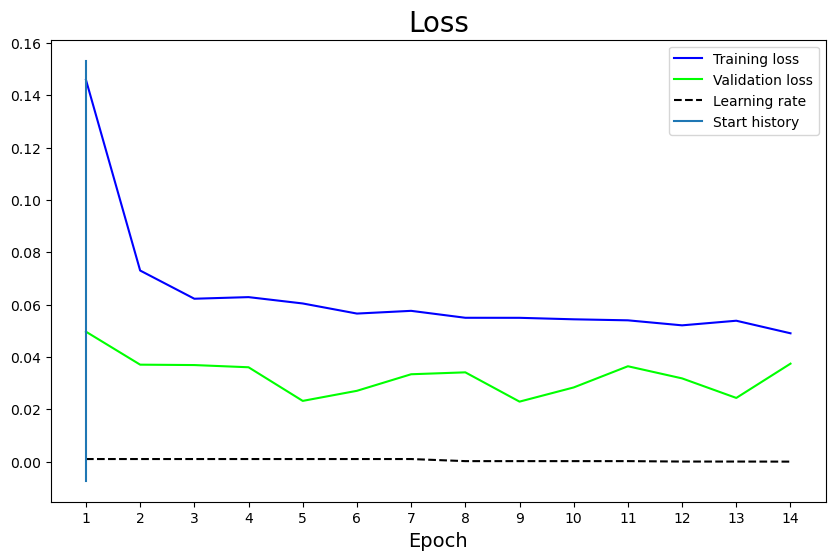

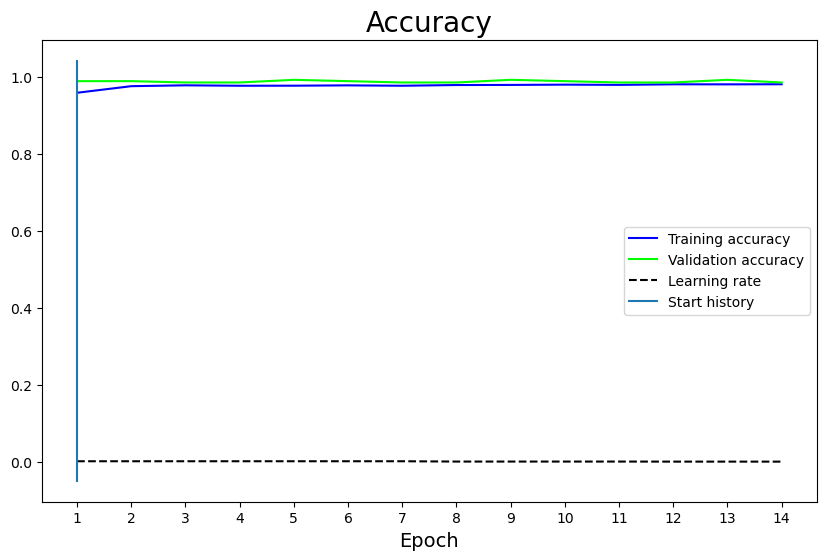

In [13]:
mlp.plot_history(model_feature_extraction_history)

# Evaluate the feature extraction model

In [14]:
model_feature_extraction_evaluation = model.evaluate(x=test_images)

63/63 [==============================] - 35s 553ms/step - loss: 0.0282 - accuracy: 0.9935


In [15]:
model_feature_extraction_evaluation

[0.028214169666171074, 0.9934999942779541]

# Create confusion matrix on all the predictions of the test images

In [16]:
y_true, y_pred = mll.plot_classification_dataset(model, test_images)

1/1 [==============================] - 1s 1s/step


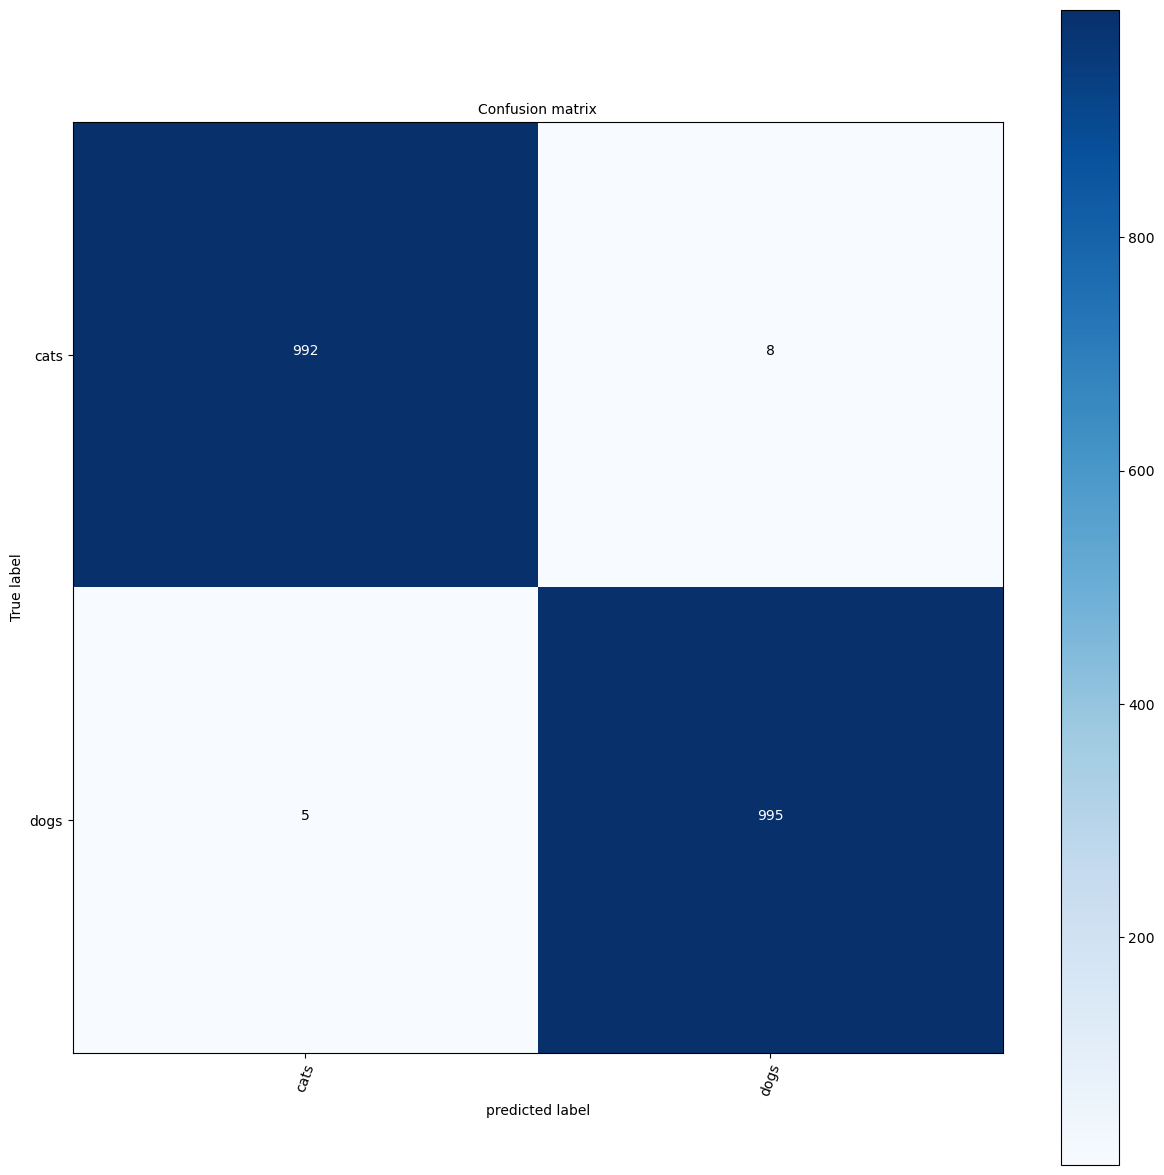

In [17]:
mlp.plot_classification_confusion_matrix(y_true=y_true, y_pred=y_pred, class_names=class_names)

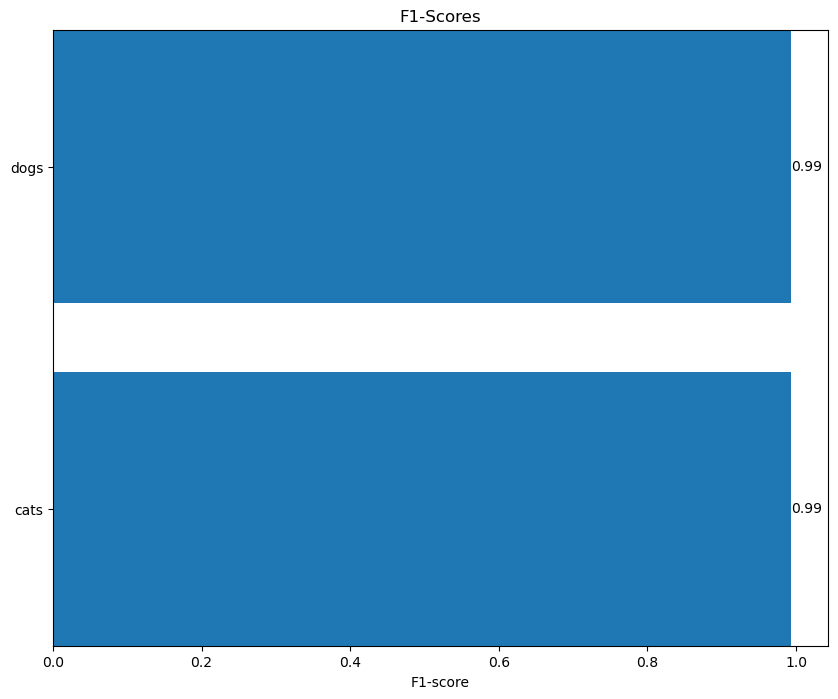

In [18]:
mlp.plot_classification_report_f1_score(y_true=y_true, y_pred=y_pred, class_names=class_names)

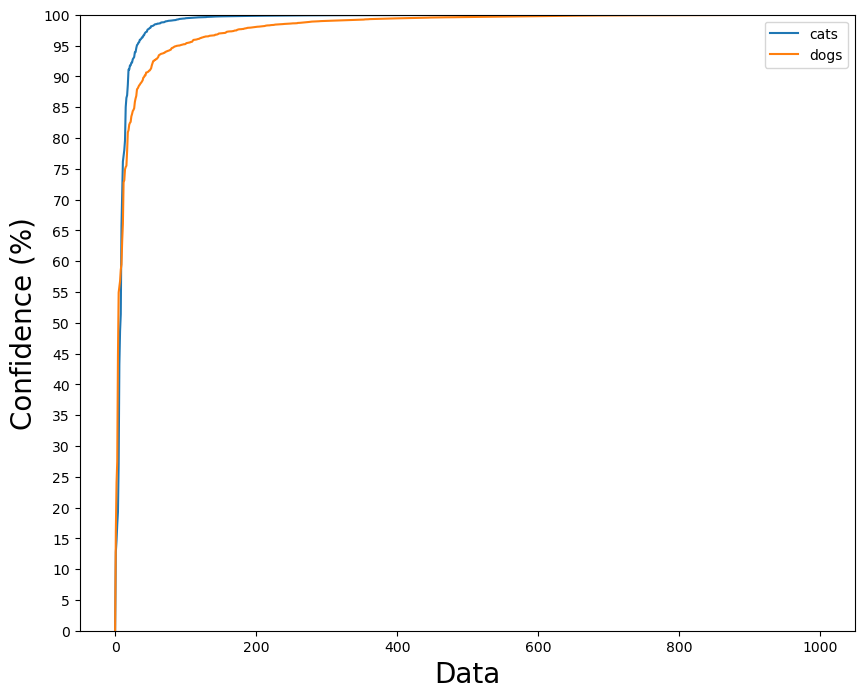

In [72]:
mlp.plot_classification_prediction_confidence(y_true=y_true, y_pred=y_pred, class_names=class_names)

# Make some predictions of our own

In [73]:
SAMPLES_DIR = "./samples"

mli.list_dir_summary(SAMPLES_DIR)

There are 0 directories, and 6 in ./samples


In [ ]:
cat = mld.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_1.jpeg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.binarize_labels(model.predict(x=mld.add_batch_to_tensor(cat)), dtype=np.int32)
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0][0]]}")

In [ ]:
cat = mld.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_2.jpeg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.binarize_labels(model.predict(x=mld.add_batch_to_tensor(cat)), dtype=np.int32)
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0][0]]}")

In [ ]:
cat = mld.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_3.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.binarize_labels(model.predict(x=mld.add_batch_to_tensor(cat)), dtype=np.int32)
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0][0]]}")

In [ ]:
dog = mld.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_1.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.binarize_labels(model.predict(x=mld.add_batch_to_tensor(dog)), dtype=np.int32)
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0][0]]}")

In [ ]:
dog = mld.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_2.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.binarize_labels(model.predict(x=mld.add_batch_to_tensor(dog)), dtype=np.int32)
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0][0]]}")

In [ ]:
dog = mld.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_3.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.binarize_labels(model.predict(x=mld.add_batch_to_tensor(dog)), dtype=np.int32)
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0][0]]}")

# Save the model so we can perform a training

In [98]:
mll.save_model_alt(model=model, directory=f"./models/{BASE_MODEL_NAME}", name="cats_dogs_feature_extraction_binary", format="h5")

In [99]:
# In case we need to load the model again
model = mll.load_model_alt(directory=f"./models/{BASE_MODEL_NAME}", name="cats_dogs_feature_extraction_binary", format="h5")

In [100]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling_2d (  (None, 1536)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_dense_layer (Dense)  (None, 1)                 1537      
                                                             

# Change the last 10 layers to be trainable

In [101]:
mll.set_trainable_on_last_n_layers(model=model, n=10, trainable=True)
mll.list_model(model=model, recursive=True)

row   | name (type)                                         | dtype   | policy        | trainable | output shape
0     | input_layer                (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | random_flip                (RandomFlip            ) | float32 | mixed_float16 | True      | (None, 224, 224, 3)     
2     | random_rotation            (RandomRotation        ) | float32 | mixed_float16 | True      | (None, 224, 224, 3)     
3     | random_height              (RandomHeight          ) | float32 | mixed_float16 | True      | (None, None, 224, 3)    
4     | random_width               (RandomWidth           ) | float32 | mixed_float16 | True      | (None, None, None, 3)   
5     | random_zoom                (RandomZoom            ) | float32 | mixed_float16 | True      | (None, None, None, 3)   
6     | input_1                    (InputLayer            ) | float32 | float32       | True      | [(None, None, None, 3)] 
7     | resc

# Recompile the model so we can use a lower learning rate which is adviced after performing feature extraction after transfer learning. The learning rate should be 10x lower then the learning rate used for feature extraction.

In [103]:
model.compile(loss=binary_crossentropy,
              optimizer=Adam(0.001 * 0.10),
              metrics=["accuracy"])

# Train the model further

In [104]:
model_2nd_pass_history = model.fit(epochs=50,
                                   x=train_images,
                                   steps_per_epoch=len(train_images),
                                   validation_data=test_images,
                                   validation_steps=int(.5 * len(test_images)),
                                   initial_epoch=len(model_feature_extraction_history.epoch) - 1,
                                   callbacks=callbacks)

Epoch 14/50
250/250 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9804
Epoch 14: val_loss did not improve from 0.02294
250/250 [==============================] - 184s 717ms/step - loss: 0.0549 - accuracy: 0.9804 - val_loss: 0.0262 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 15/50
250/250 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9808
Epoch 15: val_loss did not improve from 0.02294
250/250 [==============================] - 171s 683ms/step - loss: 0.0493 - accuracy: 0.9808 - val_loss: 0.0414 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 16/50
250/250 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9836
Epoch 16: val_loss improved from 0.02294 to 0.01871, saving model to ./checkpoints/efficientnetv2b3/model-epoch-16-val_loss-0.02.hdf5
250/250 [==============================] - 187s 748ms/step - loss: 0.0443 - accuracy: 0.9836 - val_loss: 0.0187 - val_accuracy: 0.9929 - lr: 1.0000e-04
Epoch 17/50
250/250 [==

# Save the 2nd pass model in case we want to continue

In [105]:
mll.save_model_alt(model=model, directory=f"./models/{BASE_MODEL_NAME}", name="cats_dogs_2nd_pass_binary", format="h5")

In [8]:
# In case we need to load the model again
model = mll.load_model_alt(directory=f"./models/{BASE_MODEL_NAME}", name="cats_dogs_2nd_pass_binary", format="h5")

In [9]:
model.compile(loss=binary_crossentropy,
              optimizer=Adam(0.001 * 0.10),
              metrics=["accuracy"])

# Inspect the history of fitting the feature extraction model and the 2nd pass

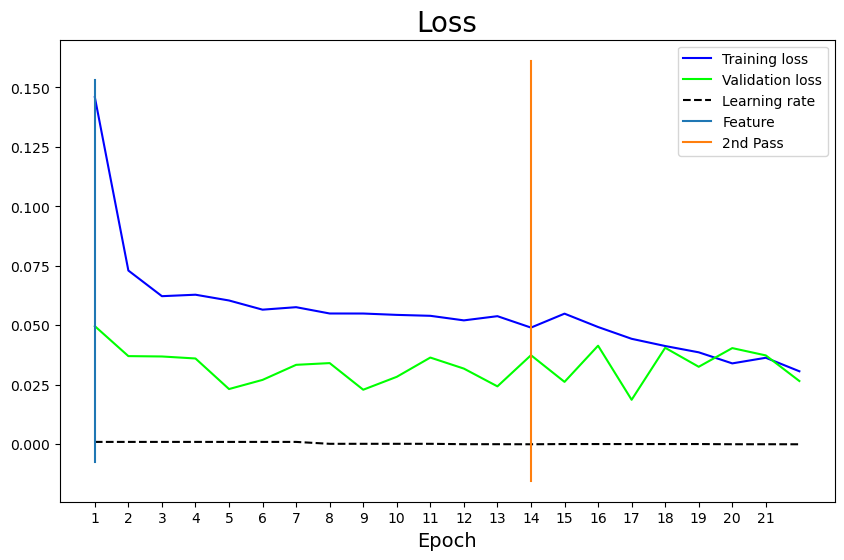

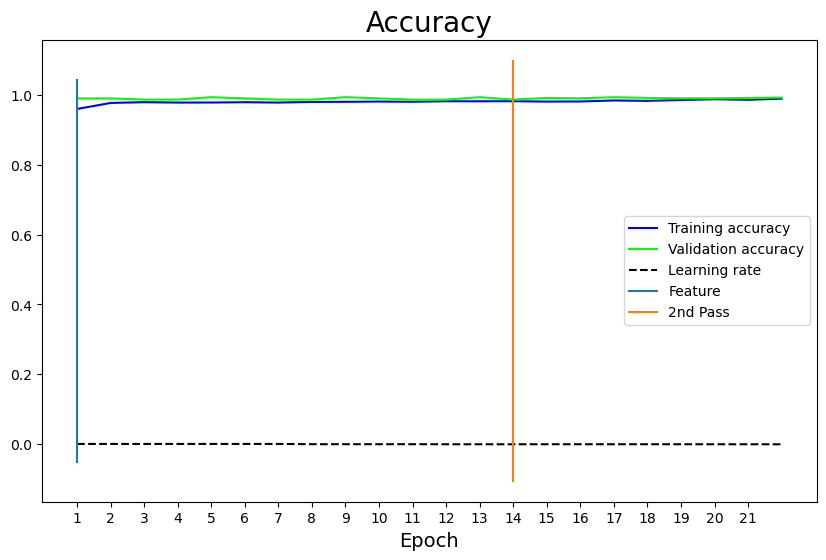

In [107]:
mlp.plot_consecutive_histories(histories=[model_feature_extraction_history, model_2nd_pass_history], labels=["Feature", "2nd Pass"])

# Evaluate the 2nd pass model

In [113]:
model_2nd_pass_evaluation = model.evaluate(x=test_images)
model_2nd_pass_evaluation

63/63 [==============================] - 35s 532ms/step - loss: 0.0250 - accuracy: 0.9935


[0.025017810985445976, 0.9934999942779541]

In [114]:
# Compare both the feature extraction evaluation and the 2nd pass evaluation
model_feature_extraction_evaluation, model_2nd_pass_evaluation

([0.028214169666171074, 0.9934999942779541],
 [0.025017810985445976, 0.9934999942779541])

# Create confusion matrix on all the predictions of the test images

2023-06-09 11:46:43.772393: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 1s/step


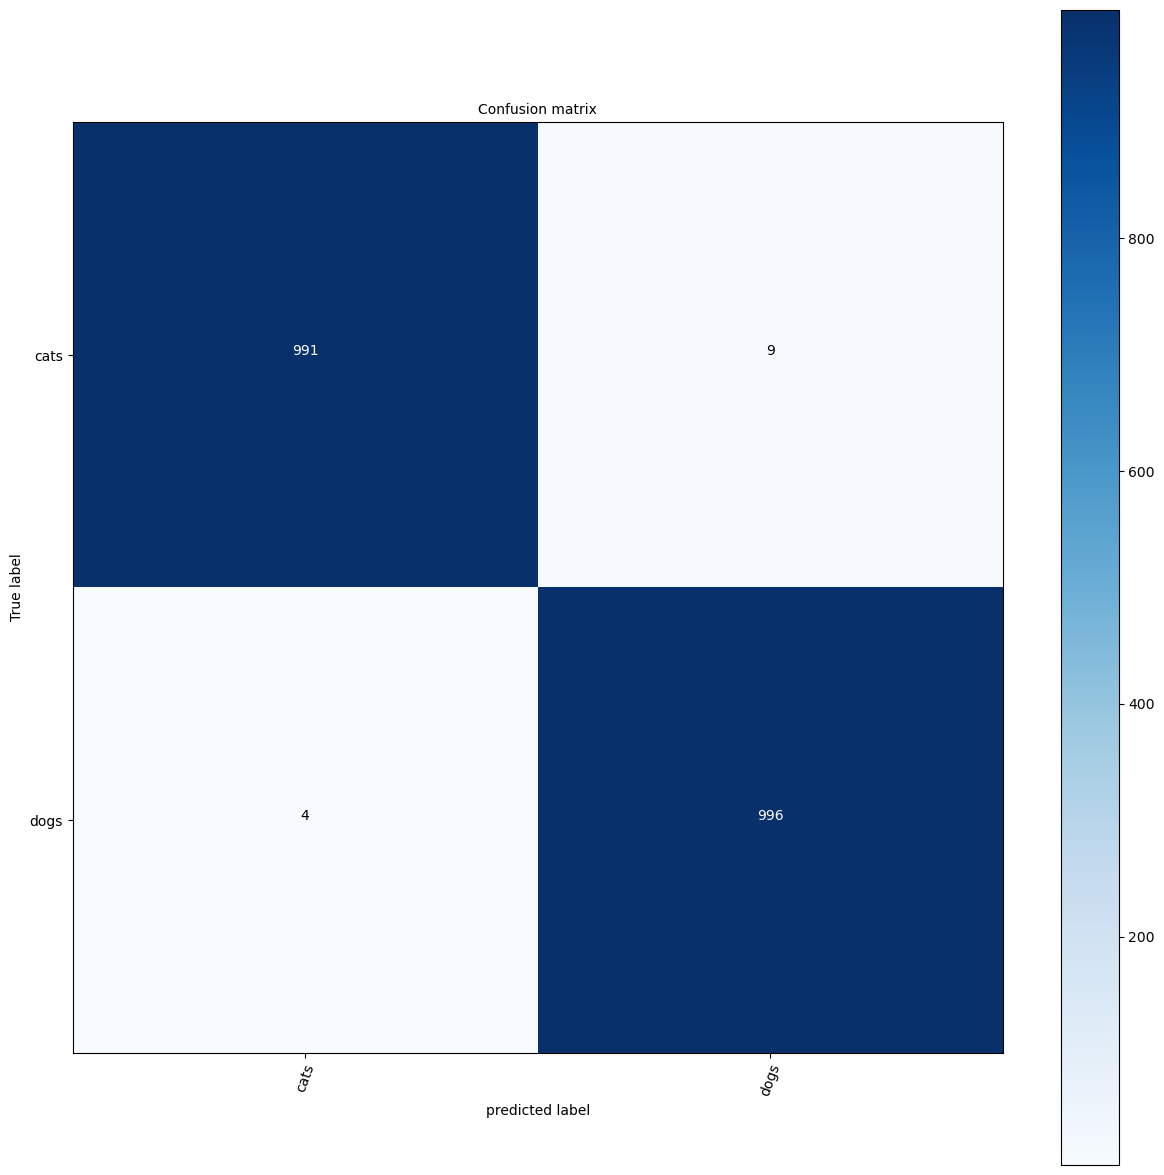

In [10]:
y_true, y_pred = mll.plot_classification_dataset(model, test_images)
mlp.plot_classification_confusion_matrix(y_true=y_true, y_pred=y_pred, class_names=class_names)

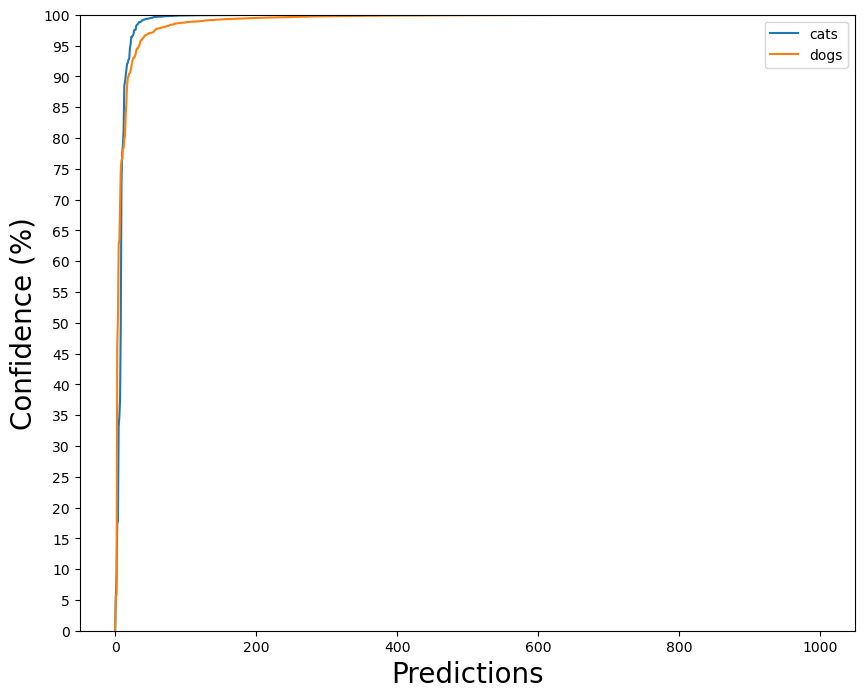

In [11]:
mlp.plot_classification_prediction_confidence(y_true=y_true, y_pred=y_pred, class_names=class_names)

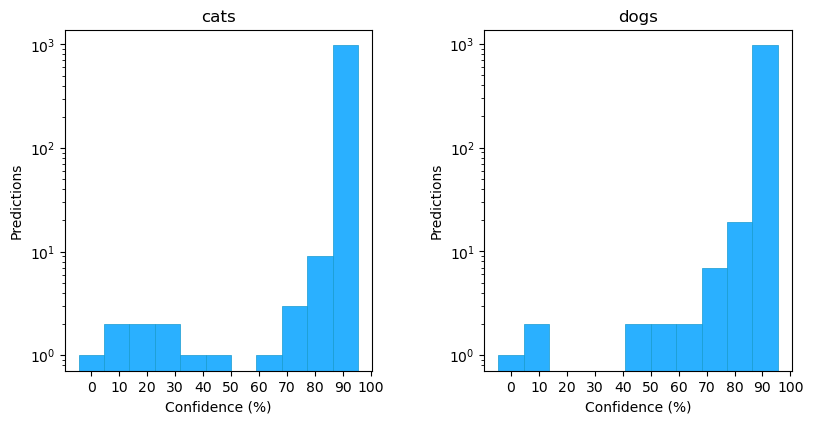

In [52]:
mlp.plot_classification_prediction_confidence_histogram(y_true=y_true, y_pred=y_pred, class_names=class_names, figsize=(8, 4))